In [1]:
import pyro
import torch
from pyro.optim import SGD, Adam
import pyro.distributions as dist
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

C:\Users\inigo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\inigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\inigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Model
We consider the thumb tack model (to see the figures you should be logged in to Moodle):

<img src="https://www.moodle.aau.dk/pluginfile.php/1695750/mod_folder/content/0/thumb_tack.png?forcedownload=1" width="600">

Recall the beta distribution 

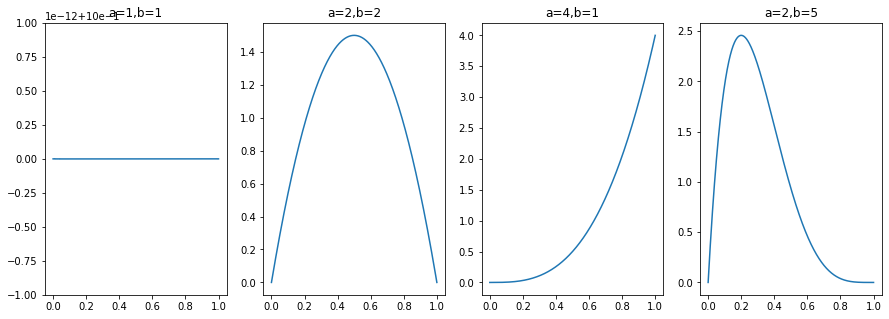

In [2]:
parameters = [(1,1), (2,2), (4,1),(2,5)]
x = np.linspace(0,1,1000)
plt.figure(figsize=(15, 5))
for idx, para in enumerate(parameters):
    plt.subplot(1, len(parameters), idx+1)
    y = beta.pdf(x, *para)
    plt.title(f'a={para[0]},b={para[1]}')
    plt.plot(x,y)

## The model

Here we define the probabilistic model. Notice the close resemblance with the plate specification above.

In [3]:
# Defines the thumb_tack model. The 'data' is a 0-1 tensor of type float  
def thumb_tack_model(data):  
    
    # Define the random variable theta
    theta = pyro.sample("theta", dist.Beta(2.0,5.0))
    
    # and now the plate holding the observations. The number of observations are determined by the data set 
    # supplied to the function
    with pyro.plate("thumb_tack_plate"):
        pyro.sample(f"obs", dist.Bernoulli(probs=theta), obs=data)

## The variational distribution

In Pyro the variational distribution is defined as a so-called guide. In this example our variational distribution is a beta distribution with parameters q_alpha and q_beta:

$$
q(\theta)= \mathit{Beta}(\theta | \alpha, \beta)
$$

In [4]:
def thumb_tack_guide(data):

    # We initialize the variational parameters q_alpha and q_beta to 1.0. Also, we constrain the parameters to be positive as per 
    # definition of the distribution
    q_alpha = pyro.param("q_alpha", torch.tensor(1.0), constraint=constraints.positive)
    q_beta = pyro.param("q_beta", torch.tensor(1.0), constraint=constraints.positive)

    # The name of the random variable of the variational distribution must match the name of the corresponding
    # variable in the model exactly.
    pyro.sample("theta", dist.Beta(q_alpha, q_beta))

## Learning

For optimizing the ELBO we rely on a standard stochastic gradient descent

In [11]:
def thumb_tack_learn(data):

    pyro.clear_param_store()

    # Define the ELBO and the optimization function
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=thumb_tack_model,
                         guide=thumb_tack_guide,
                         optim=SGD({'lr':0.001}),
                         loss=elbo)

    # Perform a fixed number of gradient steps
    num_steps = 10000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            print(f"Loss for iteration {step}: {loss}")

## Analyze

Let's take a look at the learned variational distribution 

In [9]:
def thumb_tack_analyze(data):

    # Get the values of the variational parameters
    q_alpha = pyro.param("q_alpha").item()
    q_beta = pyro.param("q_beta").item()

    mean = q_alpha/(q_alpha + q_beta)
    std = q_alpha*q_beta/(((q_alpha+q_beta)**2)*(q_alpha + q_beta + 1.0))

    print(f"q_alpha: {q_alpha}")
    print(f"q_alpha: {q_beta}")

    print(f"Mean: {mean}")
    print(f"Standard deviation: {std}")

    x = np.linspace(0.0, 1.0, 1000)
    plt.plot(x, beta.pdf(x, q_alpha, q_beta), label='Variational dist.')
    plt.plot(x,beta.pdf(x, data[data==1].shape[0]+1,data[data==0].shape[0]+1), label='True dist.')
    plt.legend()

## Perform experiments

In [12]:
# The data consists of 20 pin ups ('1') and 80 pin down ('0'). Squeeze is just used to compress the dimensions 
# from 2 to 1
data = torch.cat((torch.ones(20, 1), torch.zeros(80, 1))).squeeze()

# Do learning
thumb_tack_learn(data)

Loss for iteration 0: 225.57793521881104
Loss for iteration 100: 50.415499806404114
Loss for iteration 200: 68.37644028663635
Loss for iteration 300: 52.9821412563324
Loss for iteration 400: 59.646109104156494
Loss for iteration 500: 51.0097541809082
Loss for iteration 600: 50.71167755126953
Loss for iteration 700: 51.44629955291748
Loss for iteration 800: 59.27230095863342
Loss for iteration 900: 51.93125677108765
Loss for iteration 1000: 51.10871505737305
Loss for iteration 1100: 53.98500108718872
Loss for iteration 1200: 51.786437034606934
Loss for iteration 1300: 51.73562240600586
Loss for iteration 1400: 53.28683662414551
Loss for iteration 1500: 50.95590257644653
Loss for iteration 1600: 51.00115919113159
Loss for iteration 1700: 52.13287162780762
Loss for iteration 1800: 51.96635055541992
Loss for iteration 1900: 51.339760303497314
Loss for iteration 2000: 51.239882469177246
Loss for iteration 2100: 54.259963035583496
Loss for iteration 2200: 51.04703617095947
Loss for iteration

## Show the results

q_alpha: 19.742252349853516
q_alpha: 76.06576538085938
Mean: 0.20606054500932233
Standard deviation: 0.0016899385054537739


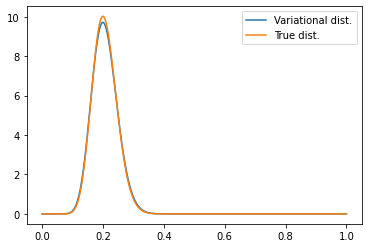

In [13]:
thumb_tack_analyze(data)